In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
# can't load here because of django imports...
#from tasks.run_alerts import interpolate_continuous_series

In [2]:
t1 = pd.to_datetime(['2017-08-01T01:00:00', '2017-08-01T06:00:00', '2017-08-01T06:30:00', '2017-08-01T07:02:00',
                     '2017-08-01T07:31:00', '2017-08-01T08:00:00', '2017-08-01T10:20:00'])
v1 = np.array([np.NaN, 12, 11.7, np.NaN, 11.8, np.NaN, 11.6])

t2 = pd.to_datetime(['2017-08-01T03:00:00', '2017-08-01T03:20:00', '2017-08-01T06:40:00', '2017-08-01T07:11:00',
                     '2017-08-01T07:34:00',  '2017-08-01T08:01'])
v2 = np.array([11.5, np.NaN, 12.2, np.NaN, 17.6, np.NaN])

In [3]:
tser1 = pd.Series(index=t1, data=v1, name='Voltage 1')
tser2 = pd.Series(index=t2, data=v2, name='Voltage 2')
df = pd.concat([tser1, tser2], axis=1)

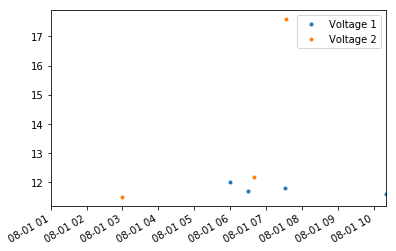

In [4]:
df.plot(style='.')

In [5]:
def interpolate_continuous_series(ser, max_dt):
    """
    Interpolates continuous portions of data in `ser`
    where the difference between the next non-null measurement
    is less than or equal to `max_dt`.  Returns a new
    linearly interpolated series of the same length as `ser`
    """

    # get the non-null measurements in this series, get the first
    # order difference of the times between non-null measurements
    # and compare them to a threshold
    ser_nn = ser[ser.notnull()]
    tflag = ser_nn.index.to_series().diff() > pd.Timedelta(max_dt)

    # group by the contiguous time bins, get back the min/max time
    # of each bin
    t_sm = tflag.cumsum()
    t_groups = t_sm.index.to_series().groupby(t_sm).apply(lambda s: ((min(s)),
                                                                      max(s)))

    #store the contiguous runs of time data which will be interpolated
    interp_dfs = []
    # (badams): couldn't find a way to do this with .groupby()
    for interval in t_groups:
        interp_dfs.append(ser.loc[interval[0]:interval[1]].interpolate())

    # merge back together with
    interp_ts = pd.concat(interp_dfs)

    # update a copy of the original series based on the index to input
    # the interpolated variables
    ser_new = ser.copy()
    ser_new.update(interp_ts)
    return ser_new

In [6]:
df.index.to_series().diff().median()

Timedelta('0 days 00:21:00')

In [7]:
df_interp = df.apply(lambda s: interpolate_continuous_series(s, '66M'))

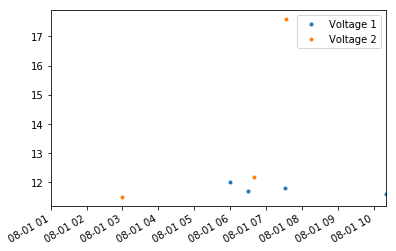

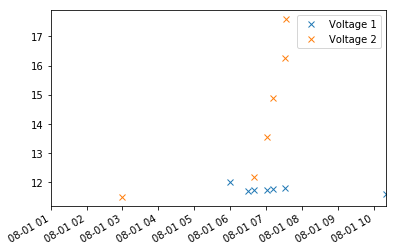

In [8]:
# plot the original, followed by the interpolated data
df.plot(style='.')
df_interp.plot(style='x')